# Exploring Ensemble Methods

In this assignment, we will explore the use of boosting. We will use the pre-implemented gradient boosted trees in GraphLab Create. You will:

* Use pandas to do some feature engineering.
* Train a boosted ensemble of decision-trees (gradient boosted trees) on the LendingClub dataset.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Evaluate the trained model and compare it with a baseline.
* Find the most positive and negative loans using the learned model.
* Explore how the number of trees influences classification performance.

Let's get started!

## Fire up Pandas, Numpy and Scikit-learn

In [650]:
import pandas as pd
import numpy as np
from sklearn import datasets

## Load the Lending Club dataset

In [651]:
loans = pd.read_csv('lending-club-data.csv')

/Users/yunpeng/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Exploring some features

Let's quickly explore what the dataset looks like. First, let's print out the column names to see what features we have in this dataset. We have done this in previous assignments, so we won't belabor this here.

In [652]:
loans.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

Here, we should see that we have some feature columns that have to do with grade of the loan, annual income, home ownership status, etc.

## Modifying the target column

The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

As in past assignments, in order to make this more intuitive and consistent with the lectures, we reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [653]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop('bad_loans',1)

## Selecting features

In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are **described in the code comments** below. If you are a finance geek, the [LendingClub](https://www.lendingclub.com/) website has a lot more details about these features.

The features we will be using are described in the code comments below:

In [654]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies
             'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

## Skipping observations with missing values

Recall from the lectures that one common approach to coping with missing values is to **skip** observations that contain missing values.

We run the following code to do so:

In [655]:
loans=loans[features+[target]].dropna()

In [656]:
# turn categorical variables to dummy variables
loans=pd.get_dummies(loans)
loans.head()

,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,last_major_derog_none,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
0,0.4,0,11,27.65,8.14350,0.0,1.0,1.0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0.8,1,1,1.00,2.39320,0.0,1.0,5.0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0,11,8.72,8.25955,0.0,1.0,2.0,1,1,...,0,0,0,0,0,0,0,1,0,0
3,0.2,0,11,20.00,8.27585,0.0,1.0,1.0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0.8,0,4,11.20,5.21533,0.0,1.0,3.0,1,1,...,0,0,0,0,0,0,0,0,0,1


## Import train data and validation data

In [657]:
#read the index documents
train_idx = pd.read_json('module-8-assignment-1-train-idx.json')
validation_idx = pd.read_json('module-8-assignment-1-validation-idx.json')

In [658]:
#pull train and test data from products data using the index docs with iloc
train_data = loans.iloc[train_idx.values.reshape((-1,))]
validation_data = loans.iloc[validation_idx.values.reshape((-1,))]
train_data.shape

(37219, 45)

In [659]:
#pull train and test data from products data using the index docs with loc
t_train_data = loans.loc[train_idx.values.reshape((-1,))]
t_train_data.shape

/Users/yunpeng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


(37219, 45)

In [660]:
(train_data - t_train_data ==0).tail()

,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,last_major_derog_none,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
122598,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
122601,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
122602,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
122604,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
122605,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Gradient boosted tree classifier

Gradient boosted trees are a powerful variant of boosting methods; they have been used to win many [Kaggle](https://www.kaggle.com/) competitions, and have been widely used in industry.  We will explore the predictive power of multiple decision trees as opposed to a single decision tree.

**Additional reading:** If you are interested in gradient boosted trees, here is some additional reading material:
* [GraphLab Create user guide](https://dato.com/learn/userguide/supervised-learning/boosted_trees_classifier.html)
* [Advanced material on boosted trees](http://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf)


We will now train models to predict `safe_loans` using the features above. In this section, we will experiment with training an ensemble of 5 trees. Now, let's use the built-in scikit learn gradient boosting classifier (sklearn.ensemble.GradientBoostingClassifier) to create a gradient boosted classifier on the training data. You will need to import sklearn, sklearn.ensemble, and numpy.

You will have to first convert the SFrame into a numpy data matrix. See the API for more information. You will also have to extract the label column. Make sure to set max_depth=6 and n_estimators=5.

In [661]:
train_y=train_data['safe_loans']
train_x=train_data.drop('safe_loans',1)
print(train_x.columns)

Index(['sub_grade_num', 'short_emp', 'emp_length_num', 'dti',
       'payment_inc_ratio', 'delinq_2yrs', 'delinq_2yrs_zero',
       'inq_last_6mths', 'last_delinq_none', 'last_major_derog_none',
       'open_acc', 'pub_rec', 'pub_rec_zero', 'revol_util',
       'total_rec_late_fee', 'int_rate', 'total_rec_int', 'annual_inc',
       'funded_amnt', 'funded_amnt_inv', 'installment', 'grade_A', 'grade_B',
       'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'purpose_car', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_house', 'purpose_major_purchase', 'purpose_medical',
       'purpose_moving', 'purpose_other', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding'],
      dtype='object')


In [662]:
train_y=train_y.values
train_x=train_x.values

In [663]:
np.any(np.isnan(train_x))

False

In [664]:
from sklearn import ensemble
model_5 = ensemble.GradientBoostingClassifier(n_estimators=5, max_depth = 6)
model_5.fit(train_x,train_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=5, presort='auto',
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

# Making predictions

Just like we did in previous sections, let us consider a few positive and negative examples **from the validation set**. We will do the following:
* Predict whether or not a loan is likely to default.
* Predict the probability with which the loan is likely to default.

First, let's grab 2 positive examples and 2 negative examples. That would be:

In [665]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,last_major_derog_none,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
22,0.2,0,3,29.44,6.30496,0.0,1.0,0.0,1,1,...,0,0,0,0,0,0,0,0,0,0
26,0.6,1,1,12.19,13.49520,0.0,1.0,0.0,1,1,...,0,0,0,0,0,0,0,0,0,0
24,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,1,...,0,0,0,0,0,0,1,0,0,0
41,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,1,...,1,0,0,0,0,0,0,0,0,0


For each row in the sample_validation_data, write code to make model_5 predict whether or not the loan is classified as a safe loan. (Hint: if you are using scikit-learn, you can use the .predict() method)

In [666]:
model_5.predict(sample_validation_data.drop('safe_loans',1))

array([ 1,  1, -1,  1])

In [667]:
sample_validation_data['safe_loans']==model_5.predict(sample_validation_data.drop('safe_loans',1))

22     True
26     True
24     True
41    False
Name: safe_loans, dtype: bool

Quiz question: What percentage of the predictions on sample_validation_data did model_5 get correct?

In [668]:
print('Answer:75%')

Answer:75%


### Prediction probabilities

For each row in the **sample_validation_data**, what is the probability (according **model_5**) of a loan being classified as **safe**? 

**Hint:** Set `output_type='probability'` to make **probability** predictions using `model_5` on `sample_validation_data`:

In [669]:
model_5.predict_proba(sample_validation_data.drop('safe_loans',1))

array([[ 0.41642331,  0.58357669],
       [ 0.46949689,  0.53050311],
       [ 0.53807792,  0.46192208],
       [ 0.39591639,  0.60408361]])

In [670]:
model_5.classes_

array([-1,  1])

Quiz Question: Which loan has the highest probability of being classified as a safe loan?

In [671]:
print('Answer: the fourth/last one')

Answer: the fourth/last one


Checkpoint: Can you verify that for all the predictions with probability >= 0.5, the model predicted the label +1?

In [672]:
print('yes')

yes


## Evaluating the model on the validation data

Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Evaluate the accuracy of the model_5 on the validation_data. (Hint: if you are using scikit-learn, you can use the .score() method)

In [673]:
model_5.score(validation_data.drop('safe_loans',1),validation_data['safe_loans'])

0.66146057733735464

Calculate the number of false positives made by the model on the validation_data.

Quiz question: What is the number of false positives on the validation_data?

In [674]:
predictions = model_5.predict(validation_data.drop('safe_loans',1))
label = validation_data['safe_loans']
false_pos=np.sum((predictions==1)&(label==-1))
print('Answer: the number of false positives is', false_pos)

Answer: the number of false positives is 1652


Calculate the number of false negatives made by the model on the validation_data

In [675]:
false_neg=np.sum((predictions==-1)&(label==1))
print('Answer: the number of false negatives is', false_neg)

Answer: the number of false negatives is 1491


## Comparison with decision trees

In the earlier assignment, we saw that the prediction accuracy of the decision trees was around **0.64** (rounded). In this assignment, we saw that **model_5** has an accuracy of **0.67** (rounded).

Here, we quantify the benefit of the extra 3% increase in accuracy of **model_5** in comparison with a single decision tree from the original decision tree assignment.

As we explored in the earlier assignment, we calculated the cost of the mistakes made by the model. We again consider the same costs as follows:

* **False negatives**: Assume a cost of \$10,000 per false negative.
* **False positives**: Assume a cost of \$20,000 per false positive.

Assume that the number of false positives and false negatives for the learned decision tree was

* **False negatives**: 1936
* **False positives**: 1503

Using the costs defined above and the number of false positives and false negatives for the decision tree, we can calculate the total cost of the mistakes made by the decision tree model as follows:

```
cost = $10,000 * 1936  + $20,000 * 1503 = $49,420,000
```

The total cost of the mistakes of the model is $49.42M. That is a **lot of money**!.

**Quiz Question**: Using the same costs of the false positives and false negatives, what is the cost of the mistakes made by the boosted tree model (**model_5**) as evaluated on the **validation_set**?

In [676]:
cost = (20000*false_pos) + (10000*false_neg)
cost

47950000

In [708]:
print('Answer:',cost)

Answer: 47950000


## Most positive & negative loans.

In this section, we will find the loans that are most likely to be predicted **safe**. We can do this in a few steps:

* **Step 1**: Use the **model_5** (the model with 5 trees) and make **probability predictions** for all the loans in the **validation_data**.
* **Step 2**: Similar to what we did in the very first assignment, add the probability predictions as a column called **predictions** into the validation_data.
* **Step 3**: Sort the data (in descreasing order) by the probability predictions.

Start here with **Step 1** & **Step 2**. Make predictions using **model_5** for examples in the **validation_data**. Use `output_type = probability`.

In [677]:
pred_proba = model_5.predict_proba(validation_data.drop('safe_loans',1))
len(pred_proba)

9284

In [678]:
len(pred_proba[:,1])

9284

In [679]:
validation_data['pred_proba'] = pred_proba[:,1]

/Users/yunpeng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Quiz question: What grades are the top 5 loans?

In [680]:
print('Answer: Grade A')

Answer: Grade A


In [681]:
validation_data.shape

(9284, 46)

In [682]:
top5=validation_data.sort_values(by=['pred_proba'],ascending=False)[:5]
top5

,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,last_major_derog_none,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,pred_proba
8021,0.4,0,4,12.73,12.167000,0.0,1.0,1.0,1,1,...,0,0,0,0,0,0,0,0,0,0.673059
3489,0.4,0,7,11.08,2.242780,0.0,1.0,0.0,1,1,...,0,0,0,0,0,0,0,0,0,0.661468
18304,0.6,0,7,14.97,5.228570,0.0,1.0,4.0,1,1,...,0,0,0,0,0,0,0,0,0,0.661468
103476,0.2,0,7,15.92,0.717964,0.0,1.0,3.0,0,1,...,0,0,0,0,0,0,0,0,0,0.661468
57584,0.2,0,7,7.55,7.304640,0.0,1.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0.661468


In [683]:
idx = top5.index.tolist()
idx

[8021, 3489, 18304, 103476, 57584]

In [684]:
validation_data.loc[idx,'grade_A':'grade_G']


,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
8021,1,0,0,0,0,0,0
3489,1,0,0,0,0,0,0
18304,1,0,0,0,0,0,0
103476,1,0,0,0,0,0,0
57584,1,0,0,0,0,0,0


Repeat this exercise to find the 5 loans (in the validation_data) with the lowest probability of being predicted as a safe loan.

In [685]:
bottom5=validation_data.sort_values(by=['pred_proba'],ascending=True)[:5]
bottom5

,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,last_major_derog_none,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,pred_proba
58794,0.8,0,2,8.66,17.62510,0.0,1.0,0.0,1,1,...,0,0,0,0,0,0,0,0,0,0.307334
84508,0.8,1,1,7.37,16.62070,0.0,1.0,1.0,1,1,...,0,0,0,0,0,0,0,0,0,0.307334
27502,1.0,0,3,8.53,14.62800,0.0,1.0,0.0,1,1,...,1,0,0,0,0,0,0,0,0,0.312806
114781,0.4,0,3,21.90,7.18760,1.0,0.0,4.0,0,1,...,0,0,0,0,0,0,0,0,0,0.315969
84921,0.8,0,9,8.54,7.48113,0.0,1.0,2.0,0,1,...,0,0,0,0,0,1,0,0,0,0.315969


In [686]:
idx_2 = bottom5.index.tolist()
idx_2

[58794, 84508, 27502, 114781, 84921]

In [687]:
validation_data.loc[idx_2,'grade_A':'grade_G']

,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
58794,0,0,1,0,0,0,0
84508,0,0,1,0,0,0,0
27502,0,0,1,0,0,0,0
114781,0,0,0,1,0,0,0
84921,0,0,1,0,0,0,0


## Effect of adding more trees

In this assignment, we will train 5 different ensemble classifiers in the form of gradient boosted trees. We will train models with 10, 50, 100, 200, and 500 trees.  We use the **max_iterations** parameter in the boosted tree module. Remember to keep max_depth = 6.

Let's get sarted with a model with **max_iterations = 10**:

In [688]:
model_10 = ensemble.GradientBoostingClassifier(n_estimators=10, max_depth = 6)
model_10.fit(train_x,train_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [689]:
model_50 = ensemble.GradientBoostingClassifier(n_estimators=50, max_depth = 6)
model_50.fit(train_x,train_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [690]:
model_100 = ensemble.GradientBoostingClassifier(n_estimators=100, max_depth = 6)
model_100.fit(train_x,train_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [691]:
model_200 = ensemble.GradientBoostingClassifier(n_estimators=200, max_depth = 6)
model_200.fit(train_x,train_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [692]:
model_500 = ensemble.GradientBoostingClassifier(n_estimators=500, max_depth = 6)
model_500.fit(train_x,train_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

## Compare accuracy on entire validation set

Now we will compare the predicitve accuracy of our models on the validation set. Evaluate the **accuracy** of the 10, 50, 100, 200, and 500 tree models on the **validation_data**. 

In [693]:
model_10.score(validation_data.drop(['safe_loans','pred_proba'], axis=1),validation_data['safe_loans'])

0.66630762602326588

In [694]:
model_50.score(validation_data.drop(['safe_loans','pred_proba'], axis=1),validation_data['safe_loans'])

0.68504954760878933

In [695]:
model_100.score(validation_data.drop(['safe_loans','pred_proba'], axis=1),validation_data['safe_loans'])

0.69021973287376126

In [696]:
model_200.score(validation_data.drop(['safe_loans','pred_proba'], axis=1),validation_data['safe_loans'])

0.68580353295993102

In [697]:
model_500.score(validation_data.drop(['safe_loans','pred_proba'], axis=1),validation_data['safe_loans'])

0.69043515725980176

Quiz Question: Which model has the best accuracy on the validation_data?

In [698]:
print('Answer: model_100')

Answer: model_100


Quiz Question: Is it always true that the model with the most trees will perform best on test data?

In [699]:
print('Answer:no')

Answer:no


## Plot the training and validation error vs. number of trees

Recall from the lecture that the classification error is defined as

$$
\mbox{classification error} = 1 - \mbox{accuracy} 
$$

In this section, we will plot the **training and validation errors versus the number of trees** to get a sense of how these models are performing. We will compare the 10, 50, 100, 200, and 500 tree models. You will need [matplotlib](http://matplotlib.org/downloads.html) in order to visualize the plots. 

First, make sure this block of code runs on your computer.

In [700]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In order to plot the classification errors (on the train_data and validation_data) versus the number of trees, we will need lists of all the errors.

**Steps to follow:**

* **Step 1:** Calculate the classification error for model on the training data (**train_data**).
* **Step 2:** Store the training errors into a list (called `training_errors`) that looks like this:
```
[train_err_10, train_err_50, ..., train_err_500]
```
* **Step 3:** Calculate the classification error of each model on the validation data (**validation_data**).
* **Step 4:** Store the validation classification error into a list (called `validation_errors`) that looks like this:
```
[validation_err_10, validation_err_50, ..., validation_err_500]
```
Once that has been completed, the rest of the code should be able to evaluate correctly and generate the plot.


Let us start with **Step 1**. Write code to compute the classification error on the **train_data** for models **model_10**, **model_50**, **model_100**, **model_200**, and **model_500**.

In [701]:
train_err_10 = 1-model_10.score(train_x,train_y)
train_err_50 = 1-model_50.score(train_x,train_y)
train_err_100 = 1-model_100.score(train_x,train_y)
train_err_200 = 1-model_200.score(train_x,train_y)
train_err_500 = 1-model_500.score(train_x,train_y)

In [702]:
training_errors = [train_err_10,train_err_50,train_err_100,train_err_200,train_err_500]
training_errors

[0.32832692979392242,
 0.28259759800102102,
 0.25339208468792818,
 0.21271393643031788,
 0.13632821945780382]

In [703]:
validation_err_10 = 1-model_10.score(validation_data.drop(['safe_loans','pred_proba'], axis=1),validation_data['safe_loans'])
validation_err_50 = 1-model_50.score(validation_data.drop(['safe_loans','pred_proba'], axis=1),validation_data['safe_loans'])
validation_err_100 = 1-model_100.score(validation_data.drop(['safe_loans','pred_proba'], axis=1),validation_data['safe_loans'])
validation_err_200 = 1-model_200.score(validation_data.drop(['safe_loans','pred_proba'], axis=1),validation_data['safe_loans'])
validation_err_500 = 1-model_500.score(validation_data.drop(['safe_loans','pred_proba'], axis=1),validation_data['safe_loans'])

In [704]:
validation_errors = [validation_err_10,validation_err_50,validation_err_100,validation_err_200,validation_err_500]
validation_errors

[0.33369237397673412,
 0.31495045239121067,
 0.30978026712623874,
 0.31419646704006898,
 0.30956484274019824]

Now, we will plot the training_errors and validation_errors versus the number of trees. We will compare the 10, 50, 100, 200, and 500 tree models. We provide some plotting code to visualize the plots within this notebook.

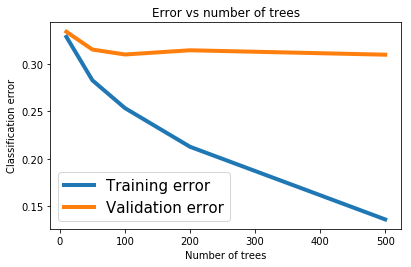

In [705]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')

Quiz question: Does the training error reduce as the number of trees increases?

In [706]:
print('Answer:yes')

Answer:yes


Quiz question: Is it always true that the validation error will reduce as the number of trees increases?

In [707]:
print('Answer:no')

Answer:no


In [710]:
import math
math.log((1-0.25)/0.25)/2

0.5493061443340549